# Connectivity metrics

>**Note** This notebook is partially inspired from the notebook [ex_geosclassic_image_analysis.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_geosclassic_image_analysis.ipynb) by Julien Straubhaar.

Connectivity is an importact concept, also related to flow and transport properties of porous media.

In this notebook, we will explore some concepts related to the estimation of connectivity functions.

First of all, import some modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import package 'geone'
import geone as gn

## Simple binary images

With Python, once defined a grid to host a given image, it is relatively easy to built some simple binary images.

In [2]:
# Define the grid that will host the binary image
nx, ny = 500, 500  # number of cells
dx, dy = 0.5, 0.5  # cell unit
ox, oy = 0.0, 0.0  # origin

Once defined a grid, we can define some simple binary image.

In [3]:
v = np.zeros((1,ny,nx))
# Select here a given image
sel_test = 1

if sel_test == 1:
    # Test 1, horizonal "line"
    v[:, 200:300,:] = 1
elif sel_test == 2:
    # Test 2, four horizontal lines
    v[:, 100:150,:] = 1
    v[:, 210:250,:] = 1
    v[:, 300:315,:] = 1
    v[:, 403:454,:] = 1
elif sel_test == 3:
    # Test 3, isolated square
    v[:,200:300,200:300] = 1
elif sel_test == 4:
    # Test 4, isolated rectangle
    v[:,200:300,100:400] = 1    
elif sel_test == 5:
    # Test 5, many isolated
    v[:,200:250,200:240] = 1
    v[:,40:90,55:88] = 1
    v[:,20:56,25:80] = 1
    v[:,110:150,189:210] = 1
    v[:,314:389,387:410] = 1

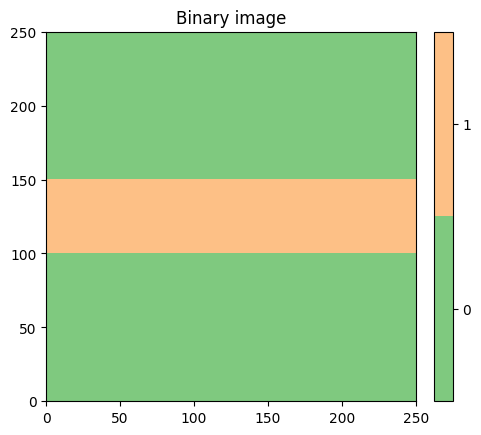

In [4]:
# Define the binary image and display it
im_bin = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=v)

# Plot
col_bin = ['#7fc97f', '#fdc086']
gn.imgplot.drawImage2D(im_bin, categ=True, categVal=[0,1], categCol=col_bin, title='Binary image')
plt.show()

### Computing the "geobodies"

Let's focus on the binary image. The *geobodies* are, in other terms, the separate *connected components* of a binary image.

For computing the "geobodies" of a binary field, we can use the function `geone.geosclassicinterface.imgGeobodyImage`.

The *connectivity* can be defined in different ways, according to the definition of "adjacent" cell.

The definition of adjacent cells depends on the keyword argument `connect_type` (string):
- `connect_type='connect_face'` (default): two grid cells are adjacent if they have a common face
- `connect_type='connect_face_edge'`: two grid cells are adjacent if they have a common face or a common edge
- `connect_type='connect_face_edge_corner'`: two grid cells are adjacent if they have a common face or a common edge or a common corner

The algorithm used is described in [Hoshen and Kopelman (1976) Physical Review B, 14(8):3438](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.14.3438). Note that also scipy has some function that can be useful for simular purposes. See for example [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html).

/home/alex/.virtualenvs/gmg/lib/python3.10/site-packages/geone/imgplot.py:408: RuntimeWarning: invalid value encountered in divide
  colorList = [cmap(x) for x in np.arange(len(dval)) * 1.0/(len(dval)-1)]


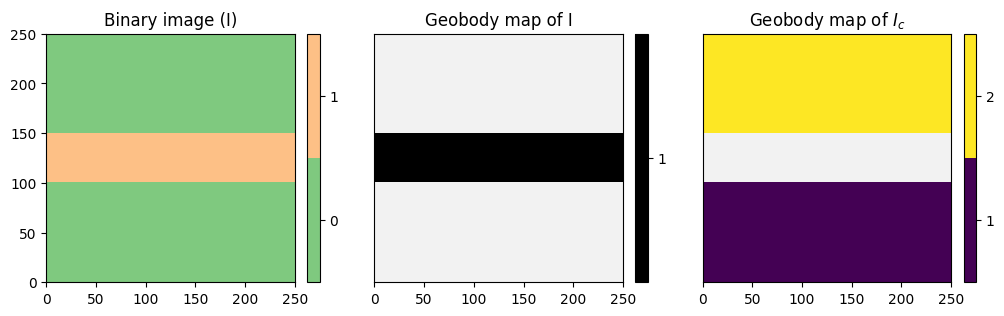

In [5]:
# Compute geobody map of the binary image
im_bin_geo = gn.geosclassicinterface.imgGeobodyImage(im_bin)
# Compute geobody map for the complementary set
im_bin_c_geo = gn.geosclassicinterface.imgGeobodyImage(im_bin, complementary_set=True)

# Display images 
plt.subplots(1,3,figsize=(12,8))

plt.subplot(1,3,1)
gn.imgplot.drawImage2D(im_bin, categ=True, categVal=[0,1], categCol=col_bin, title='Binary image (I)')

plt.subplot(1,3,2)
gn.imgplot.drawImage2D(im_bin_geo, categ=True, categVal=np.arange(1,im_bin_geo.val.max()+1), 
                       yticks=[], title='Geobody map of I')
# value 0 not included in categVal so that it is not displayed

plt.subplot(1,3,3)
gn.imgplot.drawImage2D(im_bin_c_geo, categ=True, categVal=np.arange(1,im_bin_c_geo.val.max()+1), 
                       yticks=[], title='Geobody map of $I_c$')

plt.show()

### Connectivity analysis: ''connectogram''

The function `imgTwoPointStatisticsImage` also allows to compute probability of connection between two pairs of points as function as the lag between their locations $\mathbf{x}$ (or, for for a lighter notation, simply $x$).

The input image must be the geobody image of the underlying indicator variable $I$ considered (computed using the function `imgGeobodyImage`). The output of the function `imgGeobodyImage` is a map with a different code, a label associated to every separated connected component. Let $C$ be the variable that represents the geobody label (equals to 0 if in there is no geobody), and 
let write $x\leftrightarrow y$ if the cells located at $x$ and $y$ are connected, *i.e.* in the same geobody.
Three connectivity function can be computed and specified by the keyword argument `stat_type` (string):
- $\mathbb{P}(x\leftrightarrow x+h) = \mathbb{P}(C(x) = C(x+h) > 0)$: `stat_type='connectivity_func0'`
- $\mathbb{P}(x\leftrightarrow x+h|I(x)=1) = \mathbb{P}(C(x) = C(x+h)|C(x) > 0)$: `stat_type='connectivity_func1'`
- $\mathbb{P}(x\leftrightarrow x+h|I(x)=I(x+h)=1) = \mathbb{P}(C(x) = C(x+h) > 0|C(x), C(x+h) > 0)$: `stat_type='connectivity_func2'`

See reference: *Renard P, Allard D (2013), Connectivity metrics for subsurface flow and transport. Adv Water Resour 51:168–196, [doi:10.1016/j.advwatres.2011.12.001](https://dx.doi.org/10.1016/j.advwatres.2011.12.001).*

The minimal lag, maximal lag and the lag step in each direction are expressed in **number of cells** and specified as explained above. The variable $v$ (in input image) of index `var_index` (keyword argument, default: `0`) is considered. This function launches a C program running in parallel, the number of threads used (keyword argument `nthreads`, see above) can be specified.

/home/alex/.virtualenvs/gmg/lib/python3.10/site-packages/geone/imgplot.py:408: RuntimeWarning: invalid value encountered in divide
  colorList = [cmap(x) for x in np.arange(len(dval)) * 1.0/(len(dval)-1)]


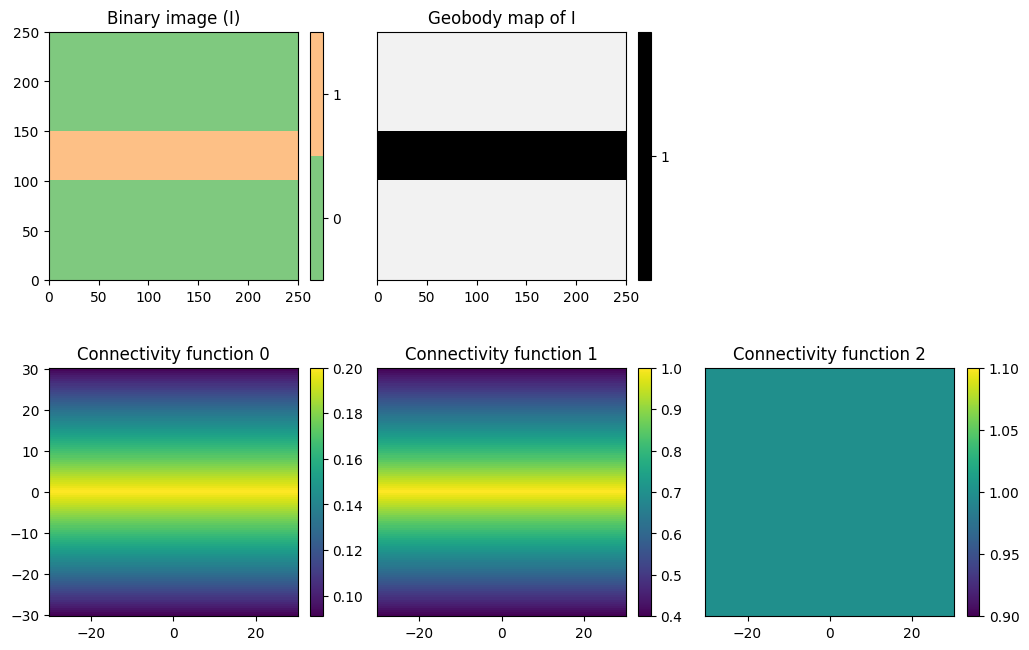

In [6]:
# Compute connectivity functions for the binary image im_bin
im_bin_geo = gn.geosclassicinterface.imgGeobodyImage(im_bin) # geobody image (already computed)

im_bin_connect0 = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_bin_geo,
                    hx_min=-60, hx_max=60, hy_min=-60, hy_max=60, stat_type='connectivity_func0')
im_bin_connect1 = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_bin_geo,
                    hx_min=-60, hx_max=60, hy_min=-60, hy_max=60, stat_type='connectivity_func1')
im_bin_connect2 = gn.geosclassicinterface.imgTwoPointStatisticsImage(im_bin_geo,
                    hx_min=-60, hx_max=60, hy_min=-60, hy_max=60, stat_type='connectivity_func2')

# Display images 
plt.subplots(2,3,figsize=(12,8))

plt.subplot(2,3,1)
gn.imgplot.drawImage2D(im_bin, categ=True, categVal=[0,1], categCol=col_bin, title='Binary image (I)')

plt.subplot(2,3,2)
gn.imgplot.drawImage2D(im_bin_geo, categ=True, categVal=np.arange(1,im_bin_geo.val.max()+1),
                       yticks=[], title='Geobody map of I')

plt.subplot(2,3,3)
plt.axis('off')

plt.subplot(2,3,4)
gn.imgplot.drawImage2D(im_bin_connect0, cmap='viridis', title='Connectivity function 0')

plt.subplot(2,3,5)
gn.imgplot.drawImage2D(im_bin_connect1, cmap='viridis', yticks=[], title='Connectivity function 1')

plt.subplot(2,3,6)
gn.imgplot.drawImage2D(im_bin_connect2, cmap='viridis', yticks=[], title='Connectivity function 2')

plt.show()